## Summarization

关于Document文档片段的总结

In [19]:
# 环境变量设置
import os
os.environ["OPENAI_API_KEY"] = "sk-xxx"
os.environ["OPENAI_API_BASE"] = "https://api.chatanywhere.tech/v1"

### 用例

假设您有一组文档(PDF、 Notion 页面、客户问题等) ，并且希望总结内容。

鉴于 LLM 在理解和综合文本方面的熟练程度，它是一个很好的工具

下面是如何使用 LLM 执行文档摘要。

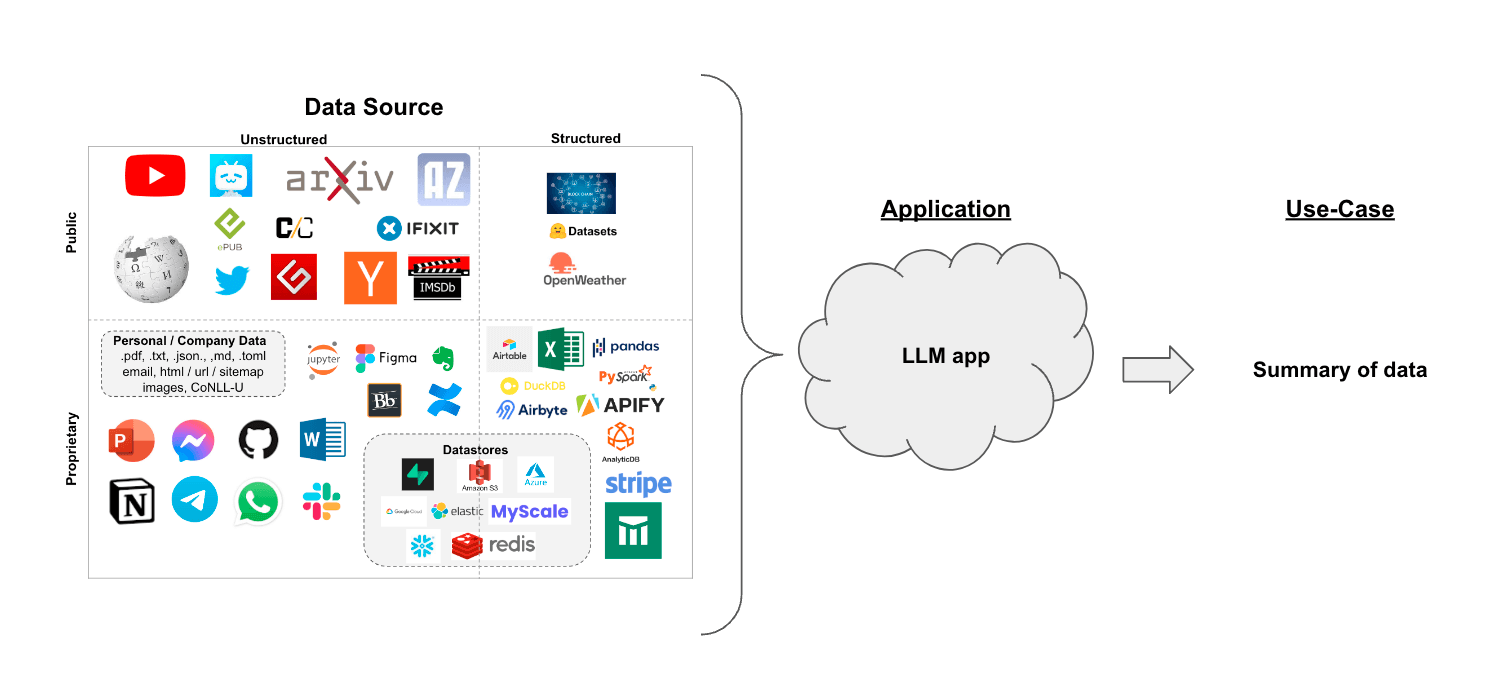

### 概述

构建摘要器的一个核心问题是如何将文档传递到 LLM 的上下文窗口。这方面的两种常见做法是:

- Stuff: 简单地将所有文档“填充”到一个提示符中。这是最简单的方法(create_stuff_document_chain)。


- Map-reduce: 在“ map”步骤中对每个文档进行总结，然后“ reduce”总结成最终的总结(MapReduceDocumentsChain)。

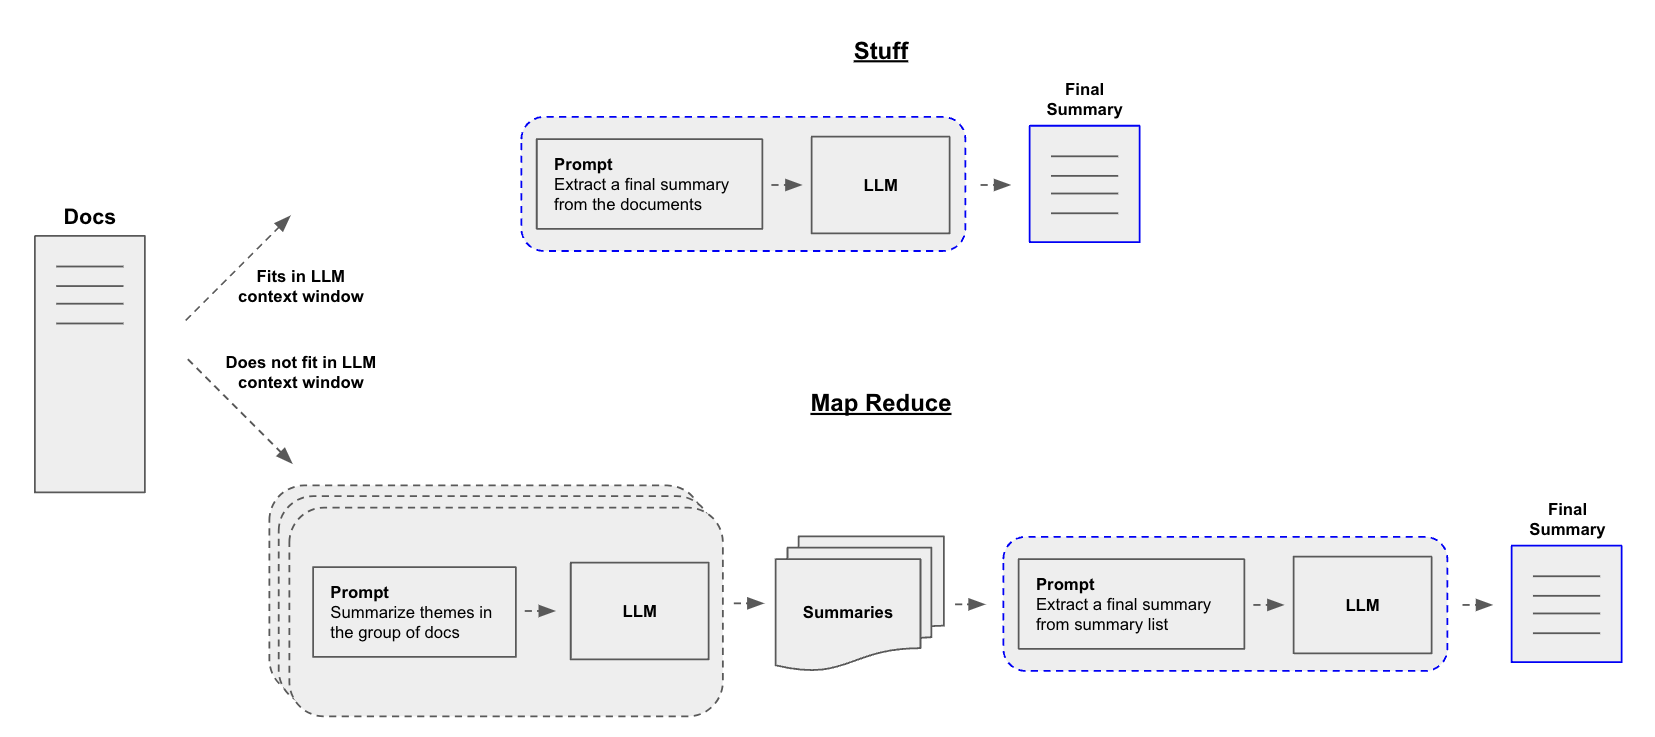



#### 简单示例

load_summarize_chain封装了任一管道的对象，提供了chain_type="map_reduce" or chain_type="refine"

如果想要总结一篇文章，只需要load_summarize_chain几行代码就可以使用，如下所示

In [3]:
! pip install --upgrade --quiet  langchain-openai tiktoken chromadb langchain langchainhub
! pip install bs4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 478.5 kB/s eta 0:00:00a 0:00:01


In [4]:
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_openai import ChatOpenAI

# 加载地址文章
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-1106")
chain = load_summarize_chain(llm, chain_type="stuff")

print(len(docs))
print(chain.invoke(docs)['output_text'])

1
The article discusses the concept of LLM-powered autonomous agents, which use large language models as their core controllers. It covers the components of these agents, including planning, memory, and tool use, as well as case studies and proof-of-concept examples. The challenges and limitations of using natural language interfaces for these agents are also discussed. The article provides citations and references for further reading.


#### Stuff

当我们使用 load_summarize_chain 和 chain_type = “stuff”时，将使用 StuffDocumentsChain。

这个链将获取一个文档列表，将它们全部插入到一个提示符中，并将该提示符传递给一个 LLM:



In [17]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import PromptTemplate

# Define prompt
prompt_template = """写出下列内容的简明摘要:
"{text}"
简明扼要:"""
prompt = PromptTemplate.from_template(prompt_template)

# Define LLM chain
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
llm_chain = LLMChain(llm=llm, prompt=prompt)


# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

docs = loader.load()
print(stuff_chain.invoke(docs)['output_text'])

本文介绍了使用LLM（大型语言模型）作为核心控制器构建自主代理的概念。文章讨论了自主代理系统的概述，包括规划、记忆和工具使用三个组件。在规划方面，文章介绍了任务分解和自我反思的方法。在记忆方面，文章讨论了短期记忆和长期记忆的类型，并介绍了最大内积搜索（MIPS）的概念。在工具使用方面，文章提到了一些案例研究，包括科学发现代理和生成代理模拟。文章还讨论了构建LLM中心代理的挑战，包括有限的上下文长度、长期规划和任务分解的困难，以及自然语言界面的可靠性。


#### Map-Reduce

map reduce 方法:

- 首先使用 LLMChain 将每个文档都生成一个单独的摘要。

- 然后，我们将使用一个 ReduceDocumentsChain 将这些摘要组合成一个全局摘要。

首先，我们指定用于将每个文档映射到单个摘要的 LLMChain:

In [24]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain_text_splitters import CharacterTextSplitter
from langchain import hub

llm = ChatOpenAI(temperature=0)

# Map
map_template = """下面是一组文档
{docs}
基于这个文档列表，请确定主要的主题有用的答案:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

ReduceDocumentsChain 处理获取文档映射结果并将其缩减为单个输出。它包装了一个通用的 CombineDocumentsChain (如 StuffDocumentsChain) ，但是增加了在将文档传递给 CombineDocumentsChain 之前折叠文档的能力，如果文档的累积大小超过 token _ max 的话。在这个示例中，我们实际上可以重用我们的链来组合我们的文档，也可以折叠我们的文档。

因此，如果映射文档中的令牌累计数量超过4000个令牌，那么我们将递归地将 < 4000个令牌的批量文档传递给 StuffDocumentsChain，以创建批处理的摘要。一旦这些批处理的摘要累计少于4000个令牌，我们将最后一次将它们全部传递给 StuffDocumentsChain 以创建最终摘要。



In [25]:
# Reduce
reduce_template = """以下是一组摘要:
{docs}
采取这些，并提炼成最终，主要主题的综合摘要。 
有用的答案:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [26]:
# Note we can also get this from the prompt hub, as noted above
reduce_prompt = hub.pull("rlm/map-prompt")

In [27]:
reduce_prompt

ChatPromptTemplate(input_variables=['docs'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'map-prompt', 'lc_hub_commit_hash': 'de4fba345f211a462584fc25b7077e69c1ba6cdcf4e21b7ec9abe457ddb16c87'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['docs'], template='The following is a set of documents:\n{docs}\nBased on this list of docs, please identify the main themes \nHelpful Answer:'))])

In [28]:

reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# 获取一个文档列表，将它们组合成一个字符串，并将其传递给一个 LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# 组合并迭代地减少映射的文档
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

In [29]:
# 通过在文档上映射链来组合文档，然后组合结果
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

Created a chunk of size 1003, which is longer than the specified 1000


In [30]:
print(map_reduce_chain.run(split_docs))

1. LLM Powered Autonomous Agents
2. Improving Model Outputs
3. Memory and Exploration
4. Approximate Nearest Neighbor Search Algorithms
5. Applications of LLM and MRKL in Autonomous Agents
6. Task Planning and Execution with LLM
7. Command and Resource Usage
8. Building a Super Mario game in Python with MVC components and keyboard control
9. Challenges and Limitations of LLM Powered Autonomous Agents
10. Applications of LLM in Autonomous Agents and Research


#### Refine

细化文档链通过循环输入文档并迭代地更新其答案来构造响应。

对于每个文档，它将所有非文档输入、当前文档和最新的中间答案传递给 LLM 链，以获得新的答案。

In [31]:
chain = load_summarize_chain(llm, chain_type="refine")
chain.run(split_docs)

'The existing summary captures the key points of the article, including the importance of task clarification, user input in code generation, practical examples, and challenges faced when building LLM-centered agents. The article discusses the advancements in LLM-powered autonomous agents, highlighting the role of user input in code generation, practical examples, and challenges faced in developing these agents. It also references various related works in the field, showcasing the ongoing research and development in LLM-centered agents.'

In [ ]:
prompt_template = """Write a concise summary of the following:
{text}
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

refine_template = (
    "Your job is to produce a final summary\n"
    "We have provided an existing summary up to a certain point: {existing_answer}\n"
    "We have the opportunity to refine the existing summary"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "Given the new context, refine the original summary in Italian"
    "If the context isn't useful, return the original summary."
)
refine_prompt = PromptTemplate.from_template(refine_template)
chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=prompt,
    refine_prompt=refine_prompt,
    return_intermediate_steps=True,
    input_key="input_documents",
    output_key="output_text",
)
result = chain({"input_documents": split_docs}, return_only_outputs=True)

In [34]:
print(result["output_text"])

Il nuovo contesto riguarda istruzioni dettagliate per scrivere codice per un progetto di gioco ispirato a Super Mario, con focus sull'architettura e l'implementazione del codice. Le informazioni aggiuntive riguardano le fasi dettagliate per scrivere il codice, inclusi nomi delle classi, funzioni, metodi necessari, e la formattazione dei file in markdown. Viene inoltre menzionata l'importanza di seguire le best practice per nomi dei file, gestione delle dipendenze e commenti nel codice. Tuttavia, è importante notare che il contesto attuale non è direttamente correlato agli agenti autonomi alimentati da LLM, i quali affrontano sfide nella pianificazione a lungo termine, nella decomposizione delle attività e nella affidabilità dell'interfaccia di linguaggio naturale.


In [35]:
print("\n\n".join(result["intermediate_steps"][:3]))

LLM Powered Autonomous Agents is a concept where agents are built using a large language model (LLM) as the core controller. The system consists of components such as planning, memory, and tool use, allowing the agent to break down tasks, learn from past actions, and access external information sources. Proof-of-concept examples demonstrate the potential of LLM as a general problem solver beyond generating content like stories and programs.

Il concetto di Agenti Autonomi Alimentati da LLM prevede agenti costruiti utilizzando un grande modello di linguaggio (LLM) come controller principale. Il sistema è composto da componenti come la pianificazione, la memoria e l'uso degli strumenti, consentendo all'agente di suddividere compiti, imparare dalle azioni passate e accedere a fonti di informazioni esterne. Esempi di proof-of-concept dimostrano il potenziale di LLM come risolutore generale di problemi al di là della generazione di contenuti come storie e programmi. La pianificazione coinvo